In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [18]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     CV_ventricles  k_ventricles    k_FEC  CV_atria   k_atria     k_BB
0         0.738144      0.276378  5.71074  0.337617  0.253067  3.34120
1         0.699821      0.289857  8.23437  0.899943  0.244791  3.36932
2         0.419685      0.310723  1.32123  1.023790  0.208773  3.22631
3         0.780850      0.326027  4.83990  0.621390  0.201804  3.25724
4         0.794527      0.395183  5.83261  0.971377  0.346727  5.50506
..             ...           ...      ...       ...       ...      ...
995       0.639511      0.285979  6.68166  0.353444  0.207574  1.25594
996       0.487964      0.201533  2.99732  0.441108  0.371365  4.35580
997       0.506433      0.380463  6.07463  0.967278  0.359592  1.50839
998       0.686527      0.255578  2.70725  0.322308  0.303793  1.98914
999       0.745125      0.288781  6.70721  0.585251  0.369692  1.75873

[1000 rows x 6 columns]


In [19]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

        A_TAT     V_TAT
0    315.4700   97.6231
1    119.7940  100.6130
2    112.3490  183.1760
3    187.0580   86.8046
4     90.6858   78.7504
..        ...       ...
175   90.0410   92.6852
176  147.1390   99.3163
177  143.7290  119.9870
178  144.0190  111.9080
179  166.9070  193.3910

[180 rows x 2 columns]


# Emulator

In [20]:
input_masked = X_all.copy()

In [21]:
y_all

,A_TAT,V_TAT
0,315.4700,97.6231
1,119.7940,100.6130
2,112.3490,183.1760
3,187.0580,86.8046
4,90.6858,78.7504
...,...,...
175,90.0410,92.6852
176,147.1390,99.3163
177,143.7290,119.9870
178,144.0190,111.9080


In [22]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values)

In [23]:
y_train

tensor([[315.4700,  97.6231],
        [119.7940, 100.6130],
        [112.3490, 183.1760],
        [187.0580,  86.8046],
        [ 90.6858,  78.7504],
        [128.7110,  81.3305],
        [ 91.2266, 107.0270],
        [217.1570, 133.9420],
        [345.6780,  95.6268],
        [190.3400, 169.0470],
        [100.9040, 159.6070],
        [187.5820, 130.6680],
        [209.2220,  99.9675],
        [132.5320, 130.0060],
        [134.7740, 116.3020],
        [129.1430, 113.0810],
        [219.8920, 105.3620],
        [179.1050,  81.1545],
        [129.2600, 158.2780],
        [183.3650, 163.8170],
        [146.7630, 132.7050],
        [129.4070, 145.1490],
        [ 89.8129, 131.0260],
        [101.7090,  88.5885],
        [160.7560, 121.6790],
        [196.4600, 119.5220],
        [130.9080, 146.3930],
        [205.4800, 142.0810],
        [ 97.6107, 102.5550],
        [125.8490,  96.9932],
        [106.0140, 104.9890],
        [157.0580, 102.1780],
        [ 97.3853, 141.1870],
        [1

In [24]:
x_train.shape

torch.Size([180, 6])

In [29]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1


In [30]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.380083, 0.799735]
[0.200153, 0.499872]
[1.20065, 8.39871]
[0.300266, 1.02989]
[0.200007, 0.49989]
[1.00205, 5.69927]


In [31]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_9690/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [32]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(CV_ventricles,)  0.000007  0.000001
(k_ventricles,)   0.000016  0.000003
(k_FEC,)          0.000017  0.000003
(CV_atria,)       0.893271  0.070229
(k_atria,)        0.074322  0.007605
(k_BB,)           0.050518  0.005762
                        S1   S1_conf
(CV_ventricles,) -0.000039  0.000232
(k_ventricles,)   0.000008  0.000369
(k_FEC,)          0.000034  0.000317
(CV_atria,)       0.874924  0.086534
(k_atria,)        0.065738  0.020876
(k_BB,)           0.046667  0.023620
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.816409  0.053738
(k_ventricles,)   0.178476  0.019191
(k_FEC,)          0.012226  0.001842
(CV_atria,)       0.000027  0.000004
(k_atria,)        0.000077  0.000013
(k_BB,)           0.000076  0.000019
                        S1   S1_conf
(CV_ventricles,)  0.809463  0.066041
(k_ventricles,)   0.171403  0.031407
(k_FEC,)          0.009394  0.010577
(CV_atria,)      -0.000045

In [33]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [34]:
x_labels.values.squeeze().tolist()

['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']

In [35]:
y_all.columns.tolist()

['A_TAT', 'V_TAT']

In [36]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

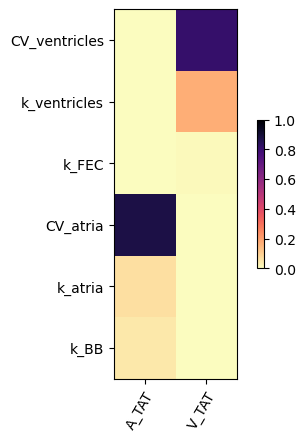

In [37]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

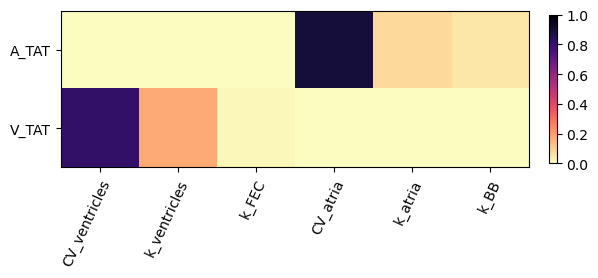

In [38]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [46]:
np.savetxt("Si_total_EP_13.csv", Si_total, delimiter=",")
np.savetxt("Si_first_EP_13.csv", Si_first, delimiter=",")

In [40]:
y_all

,A_TAT,V_TAT
0,315.4700,97.6231
1,119.7940,100.6130
2,112.3490,183.1760
3,187.0580,86.8046
4,90.6858,78.7504
...,...,...
175,90.0410,92.6852
176,147.1390,99.3163
177,143.7290,119.9870
178,144.0190,111.9080


In [41]:
y_train

tensor([[315.4700,  97.6231],
        [119.7940, 100.6130],
        [112.3490, 183.1760],
        [187.0580,  86.8046],
        [ 90.6858,  78.7504],
        [128.7110,  81.3305],
        [ 91.2266, 107.0270],
        [217.1570, 133.9420],
        [345.6780,  95.6268],
        [190.3400, 169.0470],
        [100.9040, 159.6070],
        [187.5820, 130.6680],
        [209.2220,  99.9675],
        [132.5320, 130.0060],
        [134.7740, 116.3020],
        [129.1430, 113.0810],
        [219.8920, 105.3620],
        [179.1050,  81.1545],
        [129.2600, 158.2780],
        [183.3650, 163.8170],
        [146.7630, 132.7050],
        [129.4070, 145.1490],
        [ 89.8129, 131.0260],
        [101.7090,  88.5885],
        [160.7560, 121.6790],
        [196.4600, 119.5220],
        [130.9080, 146.3930],
        [205.4800, 142.0810],
        [ 97.6107, 102.5550],
        [125.8490,  96.9932],
        [106.0140, 104.9890],
        [157.0580, 102.1780],
        [ 97.3853, 141.1870],
        [1

In [42]:
y_all.copy().drop(y_all.index[i]).values

array([[315.47  ,  97.6231],
       [112.349 , 183.176 ],
       [187.058 ,  86.8046],
       [ 90.6858,  78.7504],
       [128.711 ,  81.3305],
       [ 91.2266, 107.027 ],
       [217.157 , 133.942 ],
       [345.678 ,  95.6268],
       [190.34  , 169.047 ],
       [100.904 , 159.607 ],
       [187.582 , 130.668 ],
       [209.222 ,  99.9675],
       [132.532 , 130.006 ],
       [134.774 , 116.302 ],
       [129.143 , 113.081 ],
       [219.892 , 105.362 ],
       [179.105 ,  81.1545],
       [129.26  , 158.278 ],
       [183.365 , 163.817 ],
       [146.763 , 132.705 ],
       [129.407 , 145.149 ],
       [ 89.8129, 131.026 ],
       [101.709 ,  88.5885],
       [160.756 , 121.679 ],
       [196.46  , 119.522 ],
       [130.908 , 146.393 ],
       [205.48  , 142.081 ],
       [ 97.6107, 102.555 ],
       [125.849 ,  96.9932],
       [106.014 , 104.989 ],
       [157.058 , 102.178 ],
       [ 97.3853, 141.187 ],
       [134.413 , 102.414 ],
       [234.707 , 192.846 ],
       [117.99

In [43]:
nsamp=100
MSE = np.zeros((y_all.shape[0],y_all.shape[1]))

for i in range(y_all.shape[0]):
    y_train = torch.tensor(y_all.copy().drop(y_all.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_all.index[i]).values)
    
    y_test = torch.tensor(y_all.loc[[y_all.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_all.index[i]]].values)
    
    
    
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

0


RuntimeError: The size of tensor a (179) must match the size of tensor b (999) at non-singleton dimension 0

In [ ]:
1-MSE.mean(axis=0)/np.var(y_all,axis=0)

In [ ]:
MSE.shape

In [ ]:
MSE[0].shape

In [ ]:
np.var(y_all,axis=0).shape

In [ ]:
R2=np.zeros((18,28))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_all,axis=0))

In [ ]:
fig, ax = plt.subplots()


ax.scatter(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)))
plt.errorbar(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
y_calibration = y_all.loc[:,['V_TAT','A_TAT','LVpMax','LVedv','LVesv']]

In [ ]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [ ]:
y_calibration2=y_calibration.join(y_calibration2)

In [ ]:
MSE = np.zeros((y_calibration.shape[0],y_calibration.shape[1]))

for i in range(y_calibration.shape[0]):
    y_train = torch.tensor(y_calibration.copy().drop(y_calibration.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_calibration.index[i]).values)
    
    y_test = torch.tensor(y_calibration.loc[[y_calibration.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_calibration.index[i]]].values)
    print(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

In [ ]:
R2=np.zeros((18,5))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_calibration,axis=0))

In [ ]:
R2.std(axis=0)

In [ ]:
plt.plot(np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),'o')

In [ ]:
y_calibration.columns.values.tolist()

In [ ]:
fig, ax = plt.subplots()


ax.scatter(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)))
plt.errorbar(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
X_train = torch.tensor(input_masked.values)

In [ ]:
y_train=torch.tensor(y_calibration.values)

In [ ]:
X_train

In [ ]:
emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

In [ ]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([torch.min(X_train[:,i]).detach().numpy(),torch.max(X_train[:,i]).detach().numpy()])
    print(boundsMaxMin[i])

In [ ]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

In [ ]:
Si = []
nMod = y_train.shape[1]
nDim = X_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

In [ ]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [ ]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [ ]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [ ]:
emulator.predict(data1).detach().numpy()[:,4]

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data1[:,4],data1[:,6],emulator.predict(data1).detach().numpy()[:,3])
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

In [ ]:
Si[i].to_df()

In [ ]:
y_calibration

In [ ]:
y_calibration = y_all.loc[:,['V_TAT','LVpMax']]

In [ ]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [ ]:
y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)

In [ ]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

In [ ]:
input_masked

In [ ]:
boundsMaxMin

In [ ]:
boundsMaxMin

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = torch.tensor([100,157,0.8])

In [ ]:
boundsMaxMin

In [ ]:
np.array(boundsMaxMin)[:,0]*2

In [ ]:
p0[0]

In [ ]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],0)).detach().numpy())
    return ll

In [ ]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
p0[i].shape

In [ ]:
torch.tensor(p0[0]).shape

In [ ]:
emulator.predict(torch.tensor(p0)).shape

In [ ]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

In [ ]:
sampler.run_mcmc(p0, 40000)

In [ ]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_6_80_2timesUpper.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [ ]:
y_calibration

In [ ]:
x_out.shape

In [ ]:
emulator.predict(x_out[None,:])

In [ ]:
torch.tensor(flat_samples.T).shape

In [ ]:
plt.hist(emulator.predict(torch.tensor(flat_samples))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
working = model.predict(flat_samples)

In [ ]:
plt.plot(working,'o')

# Calibration with fixed inputs

In [ ]:
new_input=input_masked.copy()
new_input=new_input.drop(['CV_atria','a_atria','a_ventricles'],axis=1)

In [ ]:
emulator = GPE.ensemble(new_input,y_calibration,mean_func="linear",training_iter=500)

In [ ]:
nDim = new_input.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(new_input.iloc[:,i]),np.max(new_input.iloc[:,i])])
    print(boundsMaxMin[i])

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
nDim

In [ ]:
import emcee
ndim = nDim
nwalkers = 16
p0 = np.random.multivariate_normal(centre, 0.001*np.identity(ndim), size=(nwalkers))
y_val = [100,157,111,0.5]

In [ ]:
x_labels.values.squeeze().tolist()

In [ ]:
new_input.columns

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=pd.DataFrame(x).T
    x.columns = new_input.columns.values.squeeze().tolist()
    y_val = pd.DataFrame(y_val).T
    y_val.columns = y_calibration.columns.values.squeeze().tolist()
    ll =np.sum(emulator.ensemble_log_likelihood(x,y_val))
    return ll

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
sampler.run_mcmc(p0, 30000)

In [ ]:
flat_samples = sampler.get_chain(discard=6000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_5_90.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = pd.DataFrame(flat_samples.mean(axis=0)).T
x_out.columns = new_input.columns.values.squeeze()

In [ ]:
y_calibration.columns

In [ ]:
emulator.predict(x_out)

In [ ]:
plt.hist(emulator.predict(pd.DataFrame(flat_samples,columns=input_masked.columns))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

# Multi-Output GP

In [ ]:
import mogptk

In [ ]:
y_calibration

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_calibration
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration2.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_calibration2.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=4)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='Adam', lr=0.1, iters=7000, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

In [ ]:
emulator.MSE(X_test,y_test)

In [ ]:
model.plot_correlation()

In [ ]:
model.print_parameters()

In [ ]:
params?

In [ ]:
params = []

for p in model.parameters():
    params.append(p)

In [ ]:
params

In [ ]:
plt.imshow([[0.0009756545815890106, 0.0, 0.0, 0.0, 27819.543719613113, 0.0, 0.0, 0.0], [1.7460115277182566, 0.0, 0.0, 119410.25481699423, 0.0, 0.0, 0.0, 0.0], [11.369120898808664, 115237.02973475368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6990749064961943, 0.0, 0.0, 74757.56112865475, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
plt.imshow([[10.162908005474888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [37.97208882285453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [35.583222651507306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.01360765548753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_all
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_all.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='SGD', lr=0.01, iters=3500, plot=True, error='MSE', verbose=True);

In [ ]:
model.train(method='SGD', lr=0.01, iters=500, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
model.plot_correlation()

In [ ]:
fig, ax = model.plot_correlation(figsize=(25, 25))

In [ ]:
start=time.time()
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

end = time.time()
print(end - start)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
X_test

In [ ]:
import cigp_v10 as cig

In [ ]:
model = cig.cigp(torch.tensor(X_train.values),torch.tensor(y_train.values),normal_y_mode=1)

In [ ]:
import time
start = time.time()


model.train_adam(niteration=500)



In [ ]:
(torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]

In [ ]:
mogptMSE = np.array([9.10333333e-01, 1.33455636e-02, 8.78157403e-01, 6.69582124e-01,
       3.70024071e+02, 1.23460430e+02, 6.35753356e-01, 6.52791491e-04,
       3.76409392e-01, 5.31805275e-01, 1.71110574e+02, 5.49810697e+00,
       1.05649088e-01, 7.97417780e-02, 1.55348111e-01, 1.24083716e-02,
       5.45010526e-02, 5.65038223e-02, 1.02820944e-01, 1.11955787e-03,
       2.06413166e-02, 1.92173725e-02, 5.43121107e-02, 2.30204748e-02,
       1.96869906e-02, 1.69456459e-02, 1.63021757e+01, 1.57392304e+00])

In [ ]:
GPMSE = emulator.MSE(X_test,y_test).detach().numpy()
CIGMSE=((torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]).detach().numpy()

In [ ]:
fig, ax = plt.subplots()



im=plt.plot(1-GPMSE/np.var(y_test,axis=0),'o')
plt.plot(1-mogptMSE/np.var(y_test,axis=0),'o')
plt.plot(1-CIGMSE/np.var(y_test,axis=0),'o')
plt.legend(('GP','MOGPT','CIGP'))


plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
np.var(y_test,axis=0)

In [ ]:
y_all.iloc[:,[4]].max()

In [ ]:
y_all.iloc[:,[4]].min()

In [ ]:
y_all.iloc[:,[4]].std()